In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Import DID_deaths.dta
df = pd.read_stata('DID_deaths.dta')

# Add new column 'legal' to df with value 0 or value 1 if 'state_name' is 'Alabama' and 'year' is >= 1975
df['legal'] = np.where((df['state_name'] == 'Alabama') & (df['year'] >= 1975), 1, 0)

# Print the first 5 rows of df
print(df.head())

  state_name  year      mrate  legal
0    Alabama  1970  44.791061      0
1    Alabama  1971  43.962112      0
2    Alabama  1972  35.823032      0
3    Alabama  1973  30.016945      0
4    Alabama  1974  35.073116      0


# #13

**Temporal Difference:**<br>

This refers to the difference over time, specifically before and after the treatment or intervention. In our case, the change in the Minimum Legal Drinking Age (MLDA) from 21 to 19 in Alabama in 1975 is the treatment, and the years before and after this change represent the temporal difference.

**Geographical Difference:**<br>

This refers to the difference between the treatment group and the control group, which, in this case, is the difference between Alabama (where the MLDA was reduced to 19) and Arkansas (where the MLDA remained at 21). This geographical difference helps control for any unobserved time-invariant factors that may affect the outcome variable.

# #14

$$\hat{\beta^{}}^{DID} = (\bar{Y}^{treatment, after} + \bar{Y}^{treatment, before}) - (\bar{Y}^{control, after} + \bar{Y}^{control, before}) = \bigtriangleup \bar{Y}^{treatment} - \bigtriangleup \bar{Y}^{control}

The treatment group is Alabama (MLDA changed to 19). <br>
The control group is Arkansas (MLDA remained at 21).

# #15

The parallel trend assumption in the context of difference-in-difference (DID) analysis assumes that, in the absence of treatment, the average treatment and control groups would have followed parallel trends over time. This means that any differences in the outcomes between the two groups before the treatment are due to time-invariant factors and not the treatment itself. In the graph below, we observe that before 1975 (until 1974), both states exhibit comparable patterns. After the introduction (1975), the trends are not very similar between the states, at least not the first years.

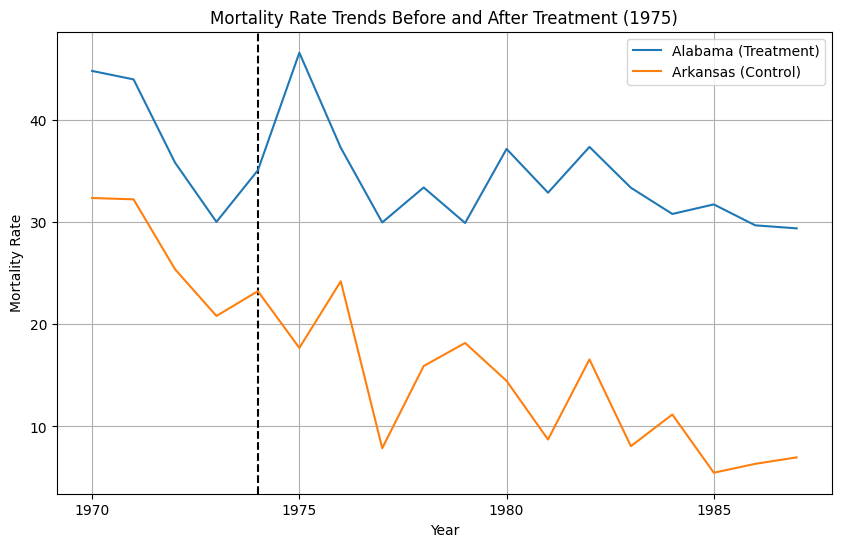

In [3]:

# Subset data for Alabama and Arkansas
alabama_data = df.loc[df['state_name'] == 'Alabama']
arkansas_data = df.loc[df['state_name'] == 'Arkansas']

# Plot trends
plt.figure(figsize=(10, 6))
plt.axvline(x=1974, color='black', linestyle='--')
plt.plot(alabama_data['year'], alabama_data['mrate'], label='Alabama (Treatment)')
plt.plot(arkansas_data['year'], arkansas_data['mrate'], label='Arkansas (Control)')
plt.title('Mortality Rate Trends Before and After Treatment (1975)')
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
# Set x-ticks to integers based on the range of years
plt.xticks(np.arange(min(df['year']), max(df['year'])+1, 5))

plt.legend()
plt.grid()
plt.show()


**Assumption:**<br>
The red line is positioned at 1974 due to the dataset only containing years, not specific dates. Consequently, all instances with the year 1975 are considered as treated. Visually, the trend appears mostly consistent before this treatment.

# #16

$$mrate_{it} = \alpha + \beta\ast Treatment + \gamma\ast Post + \delta\ast (Treatment_{i}*Post_{t}) + \epsilon_{it}

In [4]:

# Create dummy variables for treatment and post-treatment
df['Treat'] = (df['state_name'] == 'Alabama').astype(int)
df['Post'] = (df['year'] >= 1975).astype(int)

# Specify the regression equation
X = df[['Treat', 'Post', 'legal']]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df['mrate']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

# Add a new column 'Predicted' to df with predicted values from the regression model
df['Predicted'] = model.predict(X)


                            OLS Regression Results                            
Dep. Variable:                  mrate   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     43.64
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           2.05e-11
Time:                        19:44:13   Log-Likelihood:                -110.04
No. Observations:                  36   AIC:                             228.1
Df Residuals:                      32   BIC:                             234.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.8037      2.440     10.985      0.0

**Constant (Intercept):**<br> The constant term (const) is  26.8037, indicating the estimated baseline mortality rate when all other variables are zero. In this context, it represents the estimated mortality rate in the control group (Arkansas) in the pre-treatment period.

**Treat (Alabama vs. Arkansas):**<br> The coefficient for Treat is 11.1296. This suggests that, on average, the mortality rate in Alabama (the treatment group) is expected to be 16.3543 units higher than in Arkansas (the control group) in the pre-treatment period.

**Post (After vs. Before):**<br> The coefficient for Post is -14.3732. This implies that, on average, there is a decrease of 14.3732 units in the mortality rate in both Alabama and Arkansas in the post-treatment period compared to the pre-treatment period.

**legal (Interaction Term):**<br> The coefficient for legal is 10.2427. This represents the estimated difference-in-difference (DID) effect. In other words, it suggests that, on average, the mortality rate in Alabama experienced an additional increase of 10.2427 units compared to Arkansas due to the change in the Minimum Legal Drinking Age (MLDA) from 21 to 19.



# #17

In [5]:
# Create new dataframe df_did_static to prepare plotting of "DID MLDA - Static Effect"
# Define dataframe df_did_static with columns 'state_name' 'year' 'pre_value' 'did' 'post_value'
df_did_static = pd.DataFrame()

# Import columns 'state_name' and 'year' from df where year is [1970, 1974, 1987]
year = [1970, 1974, 1987]
df_did_static[['state_name', 'year']] = df.loc[df['year'].isin(year), ['state_name', 'year']].values

# Create column 'value_type' with values from value_types where 1970: pre_value, 1974: did, 1987: post_value
year_value_type = {1970: 'Pre', 1974: 'cut_off', 1987: 'Post'}
df_did_static['value_type'] = df_did_static['year'].map(year_value_type)

# Create column 'value'
df_did_static['value'] = df.loc[df['year'].isin(year), 'Predicted'].values

# Set value of did to df['mrate'] where year is 1974
df_did_static.loc[df_did_static['year'] == 1974, 'value'] = df.loc[df['year'] == 1974, 'mrate'].values

# Print df_did_static
print(df_did_static)

  state_name  year value_type      value
0    Alabama  1970        Pre  37.933253
1    Alabama  1974    cut_off  35.073116
2    Alabama  1987       Post  33.802720
3   Arkansas  1970        Pre  26.803698
4   Arkansas  1974    cut_off  23.240280
5   Arkansas  1987       Post  12.430461


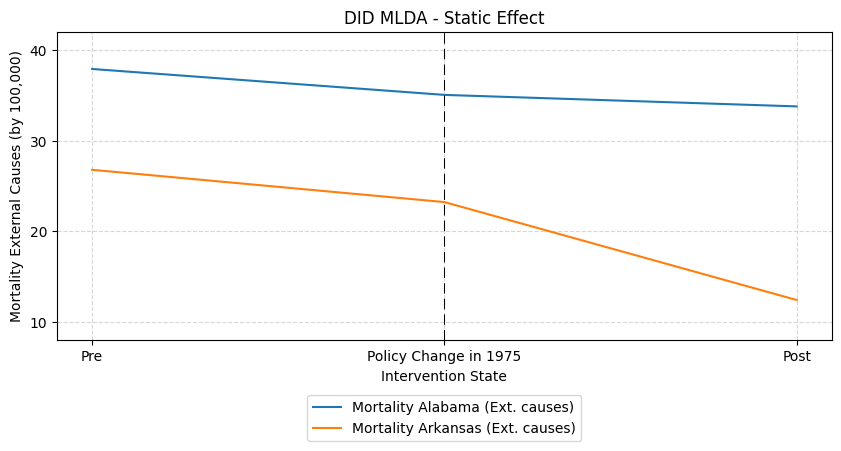

In [6]:
# Plot "DID MLDA - Static Effect"
# Set figure size
plt.figure(figsize=(10, 4))
# Plot mortality rate for Alabama and Arkansas
plt.plot(df_did_static.loc[df_did_static['state_name'] == 'Alabama', 'value_type'], df_did_static.loc[df_did_static['state_name'] == 'Alabama', 'value'], label='Mortality Alabama (Ext. causes)')
plt.plot(df_did_static.loc[df_did_static['state_name'] == 'Arkansas', 'value_type'], df_did_static.loc[df_did_static['state_name'] == 'Arkansas', 'value'], label='Mortality Arkansas (Ext. causes)')
# Plot vertical line at x=did
plt.axvline(x='cut_off', color='black', linestyle='--', linewidth=0.75, dashes=(10, 5))
# Set title, x-label, y-label, legend, grid, and x-ticks
plt.ylim(8, 42)
plt.yticks(np.arange(10, 41, 10))
plt.title('DID MLDA - Static Effect')
plt.xlabel('Intervention State')
plt.ylabel('Mortality External Causes (by 100,000)')
plt.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center')
plt.grid(linestyle='--', alpha=0.5)
plt.xticks(np.arange(3), ['Pre', 'Policy Change in 1975', 'Post'])
plt.show()

The graph reveals a common trend in external mortality between Alabama and Arkansas before the policy change in 1975. Following this change, Arkansas experiences a notably sharper decrease in external mortality compared to its pre-policy period. This is supported by our regression analysis, indicating a positive variable of approximately 10, signifying a significant disparity in post-change outcomes between the states. One plausible explanation could be the migration of 19- to 20-year-olds to Alabama due to its lower Minimum Legal Drinking Age (MLDA). Another potential factor might be spillover effects, with young individuals from Arkansas traveling to Alabama for drinking purposes during holidays.<br>

Observing the mortality graph for Alabama, it's evident that the decline in mortality slows down post-policy change. This deceleration might be attributed to several factors, including the influx of 19- to 20-year-olds from other states and the increased allowance for drinking. Additionally, the larger population in Alabama compared to Arkansas could elucidate the variance in proportional changes in mortality per 100,000 individuals, as a higher population of young people often correlates with elevated mortality rates.

# #18

Adding information on the mortality rates specifically for the age group 15-17 can enhance the precision and reliability of our analysis, providing a more nuanced understanding of the impact of the Minimum Legal Drinking Age (MLDA) change. Here's a potential regression set-up:

$$mrate_{it} = \alpha + \beta\ast Treatment + \gamma\ast Post + \delta\ast (Treatment_{i}*Post_{t}) + \theta*Teen_{it} + \zeta *(Treatment_{i}*Teen_{t}) + \epsilon_{it}

**Results Supporting Original Findings:**<br>
If the coefficient for Teen is not statistically significant, it suggests that the MLDA change did not have an impact on the mortality rate for the age group 15-17 in Alabama compared to Arkansas. This would provide additional support for our original findings. As they dont drink and mortality are not affected, it supports our findings that MLDA is the causal effect. 

**Results Contradicting Original Findings:**<br>
If the coefficient for Teen is statistically significant and negative, it would imply that the MLDA change had a mitigating effect on the mortality rate for the age group 15-17 in Alabama compared to Arkansas. This could pose a challenge to the original interpretation, suggesting that the MLDA change may have had a protective effect on the younger age group.

If the coefficient for Teen is statistically significant and positive, something else than MLDA have had an impact on the mortality rate for the age group 15-17 in Alabama compared to Arkansas. This would contradict our original findings because teens that are not allowed to drink, are affected. This means that mortality is affected by something else than MLDA.

# #19

We are interested in how the impact of a change in MLDA changes over time. To do this, we need a regression model with fixed effects, both for states and time.

$$mrate_{ist} = \alpha_{i} + \lambda_{t} + \beta\ast Treatment_{is} + \gamma\ast Post_{it} + \delta\ast (Treatment_{is}*Post_{it}) + \epsilon_{ist} 


$$mrate_{ist}

- is the mortality rate for state ii in year tt.

$$\alpha_{i}

- is a state fixed effect, capturing time-invariant heterogeneity across states.

$$\lambda_{t}

- is a year fixed effect, capturing common shocks affecting all states in a given year.

$$Treatment_{is} 

- is a dummy variable that equals 1 for the treated states (where MLDA changed) and 0 for the control states.

$$Post_{it}

- is a dummy variable that equals 1 for the post-treatment years and 0 for the pre-treatment years.

$$Treatment_{is}*Post_{it}

- is the interaction term between treatment and post-treatment indicators, capturing the differential effects over time.

# #20

**State fixed effect (a)**<br>

**Capture:** "a" represents the state fixed effects<br>
**Interpretation:** This captures time-invariant heterogeneity across states that could affect the mortality rate. It controls for any unobserved factors that are constant over time and specific to each state.<br>
**Example:** If there are differences in healthcare infrastructure, cultural norms, or socioeconomic conditions that are relatively constant over time and vary across states, "a" would capture these differences. For example, states with different levels of urbanization or healthcare policies.

**Year Fixed Effect (λ)**<br>

**Capture:** (λ) represents the year fixed effect.<br>
**Interpretation:** This captures common shocks or trends affecting all states in a given year. It controls for factors that vary across years and affect all states simultaneously.<br>
**Example:** Economic recessions, nationwide health epidemics, or changes in federal policies that impact all states in a particular year would be captured by λ. For instance, the year fixed effect would help control for a nationwide increase in awareness and public health initiatives that affect mortality rates across all states in a specific year.


# #21


Yes, including the alcohol tax variable in the event study regression equation would likely be a useful addition to the analysis. Here's how we could modify the equation to incorporate this variable:

$$mrate_{ist} = \alpha_{i} + \lambda_{t} + \beta\ast Treatment_{is} + \gamma\ast Post_{it} + \delta\ast (Treatment_{is}*Post_{it}) + \eta*Tax_{ist} + \epsilon_{ist} 

**Control for Confounding Factors:**

Alcohol tax can be associated with both changes in MLDA and mortality rates. Including it in the model helps control for potential confounding, ensuring that observed effects are more likely attributable to the change in MLDA rather than changes in alcohol taxes.

**Capture Additional Policy Effects:**

Alcohol tax is a policy variable that may independently affect mortality rates. Including it allows for the identification of the specific impact of changes in alcohol taxes on mortality rates, beyond the effect of MLDA changes.